The goal of this notebook is to gather common methods for differentiation for comparison across a suite of examples. 

References:

[1] Numerical differentiation of experimental data: local versus global methods- K. Ahnert and M. Abel  
[2] Numerical Differentiation of Noisy, Nonsmooth Data- Rick Chartrand  
[3] The Solution Path of the Generalized LASSO- R.J. Tibshirani and J. Taylor

# Load

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
from scipy import interpolate, fftpack, integrate, stats, sparse
import warnings

In [3]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['scatter.marker'] = '.'

In [4]:
from importlib import import_module, reload
from sys import path

In [5]:
path.append('../../')
import prime

In [6]:
from scipy import signal

# Examples

In [7]:
def plot_example(diff_method, t, data_f, res_f, sigmas):
    fig, axes = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])
    
    res = diff_method.d(np.vstack([data_f(t, s) for s in sigmas]), t)
    for i, s in enumerate(sigmas):
        axes[i].plot(t, res[i])
        axes[i].plot(t, res_f(t))
        axes[i].set_title("Noise: $\sigma$={}".format(s))

## Example 1: Smooth derivative

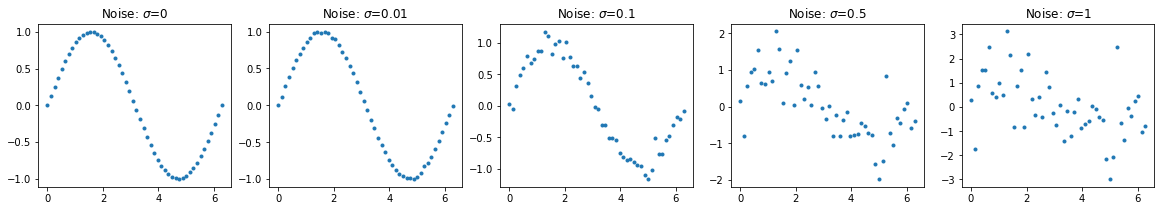

In [8]:
def noisy_sin(x, sigma):
    '''Sine with gaussian noise.'''
    np.random.seed(17)
    return np.sin(x) + np.random.normal(loc=0, scale=sigma, size=x.shape)

sigmas = [0, 0.01, 0.1, .5, 1]
fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])

x = np.linspace(0, 2*np.pi, 50)
for axs, s in zip(ax, sigmas): 
    axs.scatter(x, noisy_sin(x, s))
    axs.set_title("Noise: $\sigma$={}".format(s))

### Finite differences

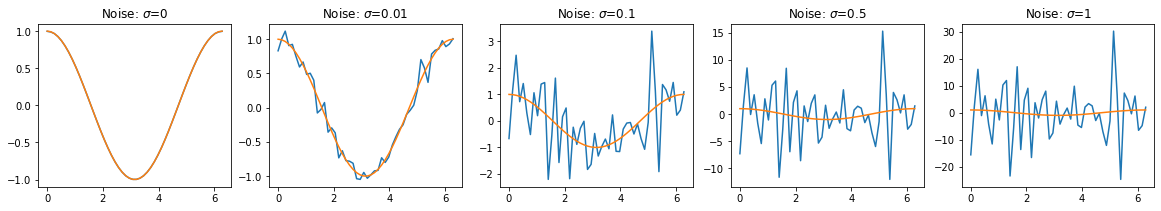

In [9]:
fd = prime.FiniteDifference(3, symmetric=True)
plot_example(fd, x, noisy_sin, np.cos, sigmas)

### Savitzky-Golay Filter
The window size is a hyper-parameter.

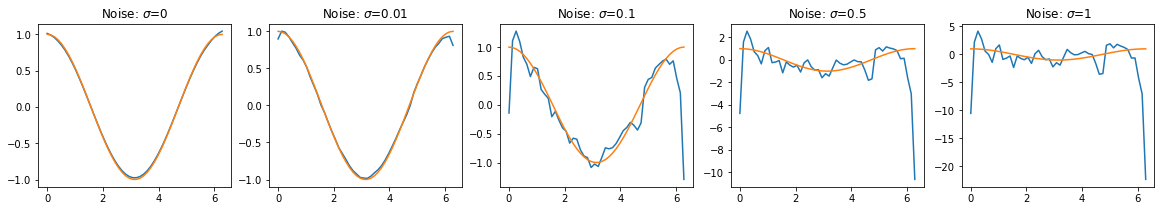

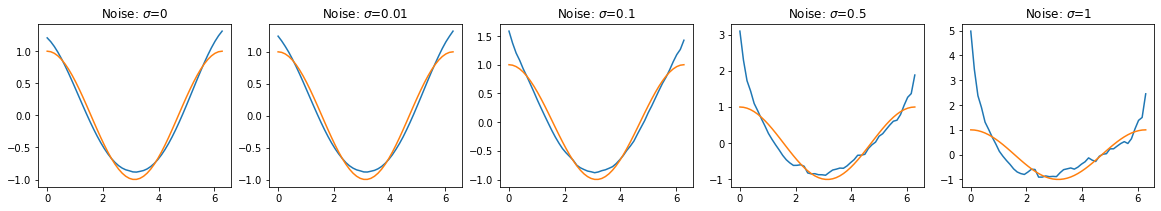

In [10]:
sg = prime.SavitzkyGolay(left=.5, right=.5, order=2)
plot_example(sg, x, noisy_sin, np.cos, sigmas)

sg = prime.SavitzkyGolay(left=3, right=3, order=3)
plot_example(sg, x, noisy_sin, np.cos, sigmas)

### Splines
Smoothing is a hyper-parameter. The Spline functions have re-run functionality built-in so cross-validation should take advantage of this. Also, the data may benefit greatly from binning and re-weighting (weights are an available parameter--they change the definition of the loss function).

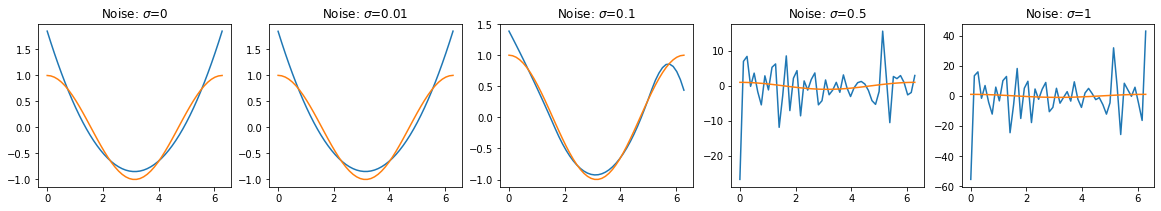

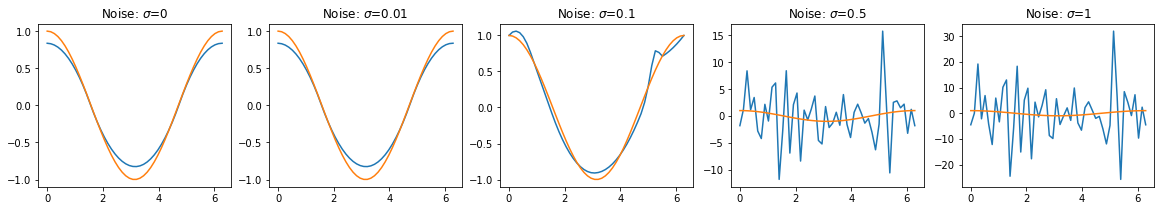

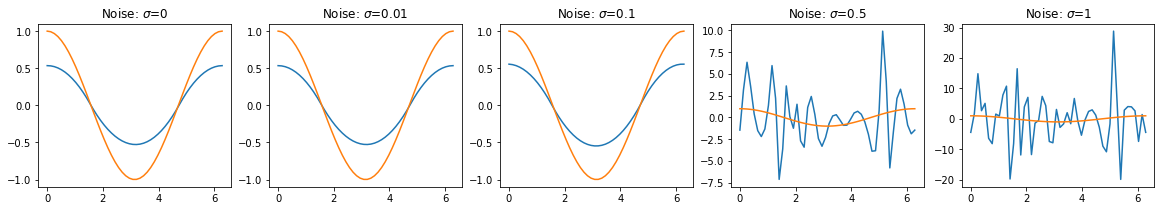

In [11]:
spl = prime.Spline(.5)
plot_example(spl, x, noisy_sin, np.cos, sigmas)
spl = prime.Spline(.5, periodic=True)
plot_example(spl, x, noisy_sin, np.cos, sigmas)
spl = prime.Spline(5, periodic=True)
plot_example(spl, x, noisy_sin, np.cos, sigmas)

### Spectral method
Add your own filter!

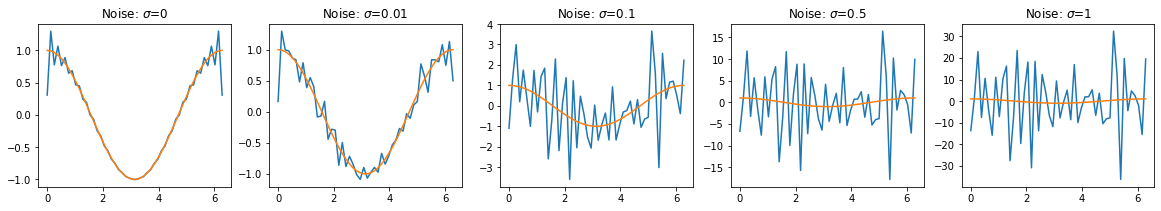

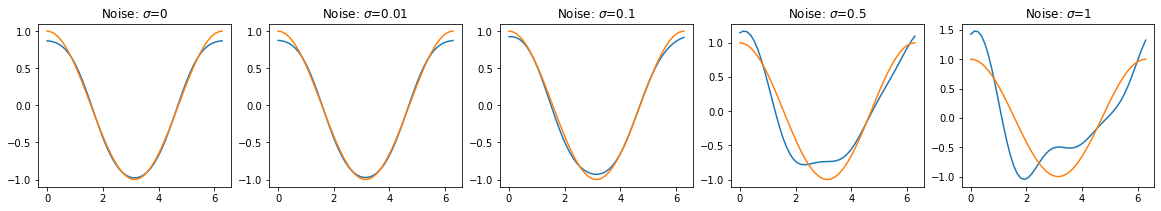

In [12]:
no_filter =  prime.Spectral()
yes_filter = prime.Spectral(filter=np.vectorize(lambda f: 1 if abs(f) < 0.5 else 0))

plot_example(no_filter, x, noisy_sin, np.cos, sigmas)
plot_example(yes_filter, x, noisy_sin, np.cos, sigmas)

### Total Variational Derivative

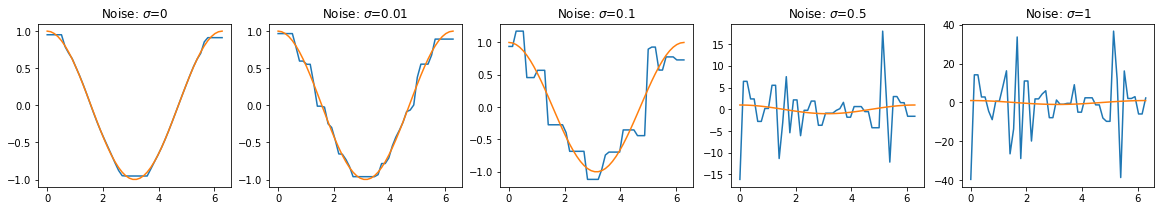

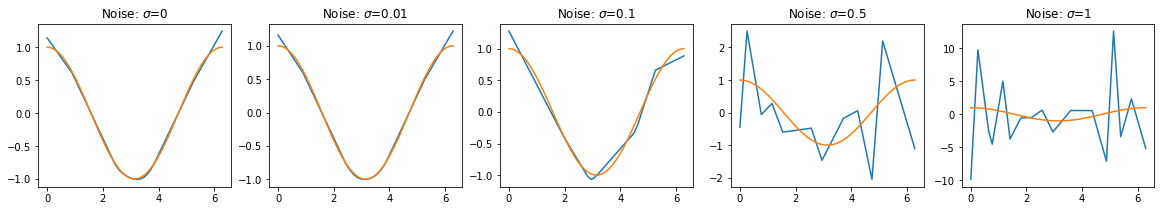

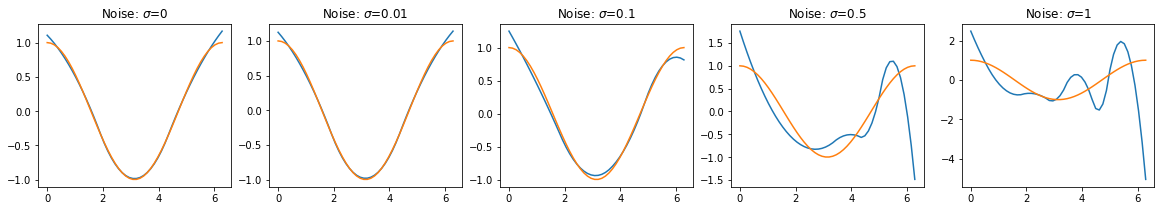

In [13]:
tvd =  prime.TrendFiltered(alpha=1e-3, order=0, max_iter=1e6)
plot_example(tvd, x, noisy_sin, np.cos, sigmas)

tvd =  prime.TrendFiltered(alpha=1e-3, order=1, max_iter=1e6)
plot_example(tvd, x, noisy_sin, np.cos, sigmas)

tvd =  prime.TrendFiltered(alpha=1e-3, order=2, max_iter=1e6)
plot_example(tvd, x, noisy_sin, np.cos, sigmas)

## Example 2: Derivative with jump

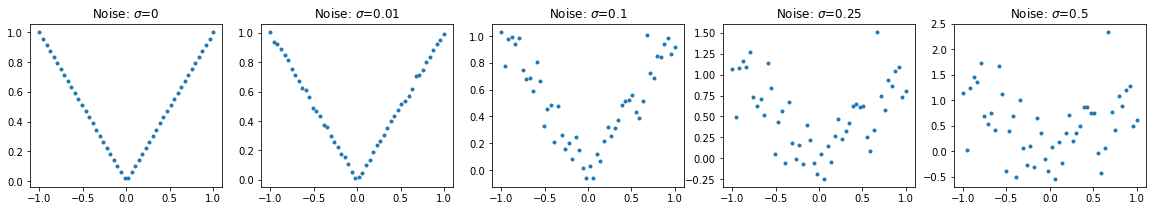

In [14]:
def noisy_abs(x, sigma):
    '''Sine with gaussian noise.'''
    np.random.seed(17)
    return np.abs(x) + np.random.normal(loc=0, scale=sigma, size=x.shape)

d_abs = lambda x: x/abs(x)

sigmas = [0, 0.01, 0.1, .25, 0.5]
fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])

x = np.linspace(-1, 1, 50)
for axs, s in zip(ax, sigmas): 
    axs.scatter(x, noisy_abs(x, s))
    axs.set_title("Noise: $\sigma$={}".format(s))

### Finite differences

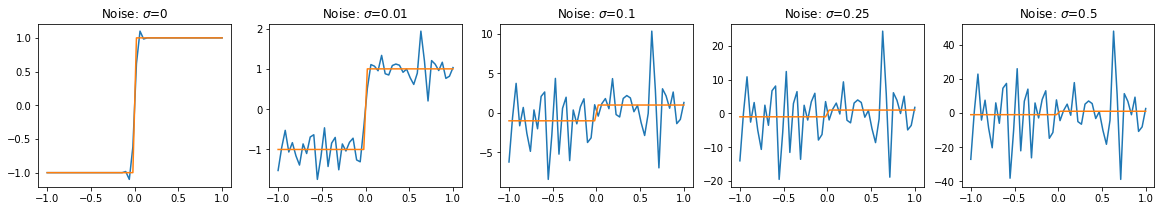

In [15]:
fd = prime.FiniteDifference(k=3)
plot_example(fd, x, noisy_abs, d_abs, sigmas)

### Savitzky-Galoy Filter

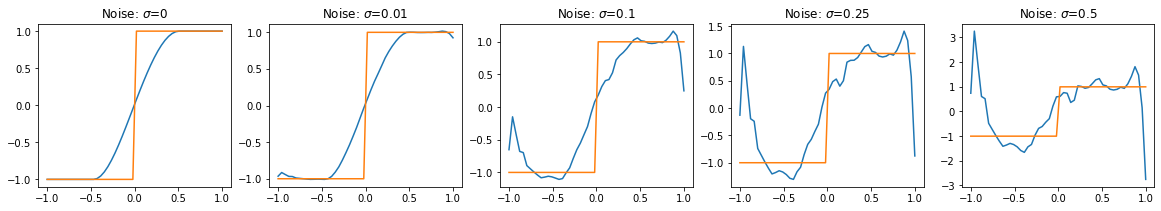

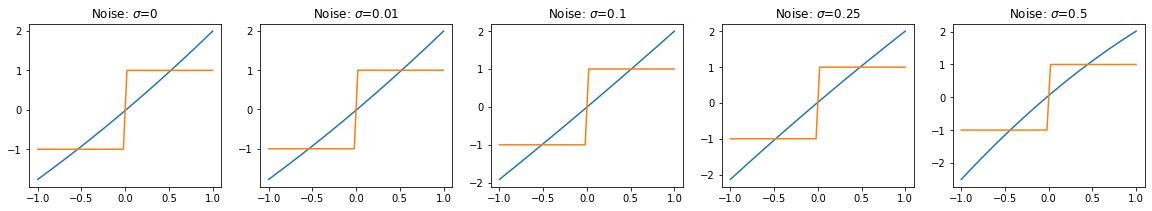

In [16]:
sg = prime.SavitzkyGolay(left=.5, right=.5, order=2)
plot_example(sg, x, noisy_abs, d_abs, sigmas)

sg = prime.SavitzkyGolay(left=3, right=3, order=3)
plot_example(sg, x, noisy_abs, d_abs, sigmas)

### Splines

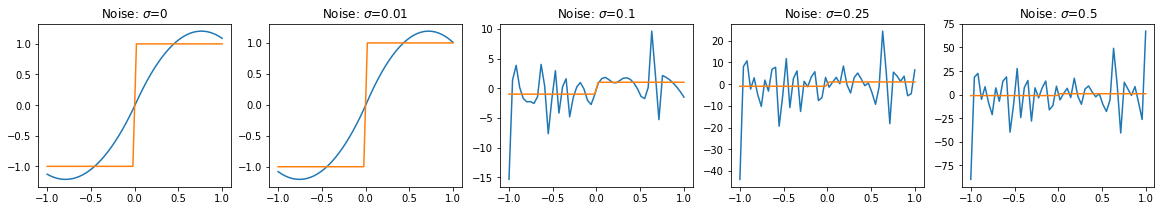

In [17]:
spl = prime.Spline(.1)
plot_example(spl, x, noisy_abs, d_abs, sigmas)

### Spectral Method

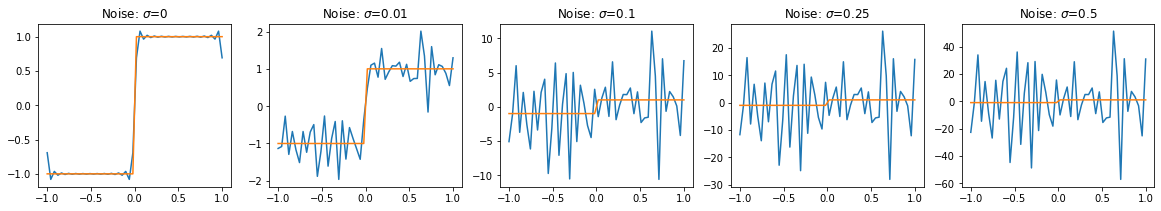

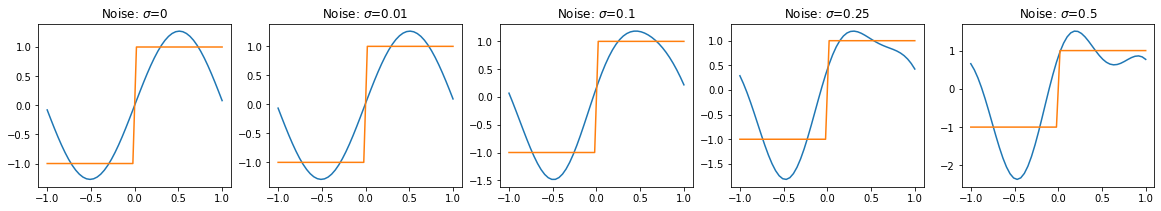

In [18]:
no_filter =  prime.Spectral()
yes_filter = prime.Spectral(filter=np.vectorize(lambda f: 1 if abs(f) < 1 else 0))

plot_example(no_filter, x, noisy_abs, d_abs, sigmas)
plot_example(yes_filter, x, noisy_abs, d_abs, sigmas)

### Total Variational Derivative

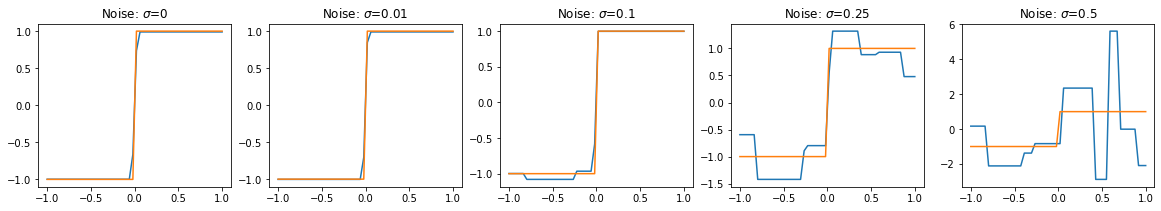

In [19]:
tvd =  prime.TrendFiltered(alpha=1e-3, order=0, max_iter=1e5)
plot_example(tvd, x, noisy_abs, d_abs, sigmas)